# Convolutionnal Generative Adversarial Networks
## Initialisation and dataset preparation

First, let us import the required libraries.

In [1]:
import tensorflow as tf
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, stft, istft
import matplotlib.pyplot as plt
import librosa
import librosa.display
from misceallaneous import getWavFileAsNpArray, displaySpectrogram
from IPython.display import Audio

Then, let us include the dataset.

The dataset is made of two files: `clean/p1.wav`and `white/p1.wav` which are converted into arrays of `int32` and then split into segments of `samples_length`.

The goal of the CGAN here is to predict the clean sample, when fed with the white one.

In [163]:
samplerate = 12000
nperseg = 1024

clean = getWavFileAsNpArray("../dataset_2/clean/p1.wav")
white = getWavFileAsNpArray("../dataset_2/white/p1.wav")
clean = np.array(clean, dtype="int32")
white = np.array(white, dtype="int32")

clean_dataset = []
white_dataset = []

samples_length = nperseg

for i in range(0, clean.shape[0]-samples_length, samples_length):
    clean_dataset.append(clean[i:i+samples_length])
    white_dataset.append(white[i:i+samples_length])
clean_dataset = np.array(clean_dataset)
white_dataset = np.array(white_dataset)

The size of the data set is (in the shape `(number of segments, segment size)`:

In [164]:
print(clean_dataset.shape)
print(white_dataset.shape)

(10659, 1024)
(10659, 1024)


## Test visualisation
We create an array `Vxx_input_test` which is displayed to show the typical content of the clean aimed output.

It is built from the five first samples of the clean dataset.

The function `displaySpectrogram` is defined in the file `miscellaneous.py`.

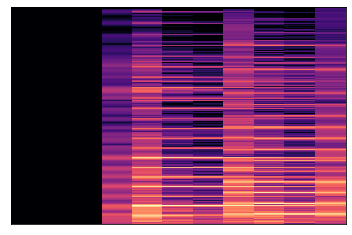

In [165]:
input_test0 = np.reshape(clean_dataset[0, :], (1, clean_dataset.shape[1]))
input_test1 = np.reshape(clean_dataset[1, :], (1, clean_dataset.shape[1]))
input_test2 = np.reshape(clean_dataset[2, :], (1, clean_dataset.shape[1]))
input_test3 = np.reshape(clean_dataset[3, :], (1, clean_dataset.shape[1]))
input_test4 = np.reshape(clean_dataset[4, :], (1, clean_dataset.shape[1]))
b0 = np.reshape(input_test0.T, (clean_dataset.shape[1],))
b1 = np.reshape(input_test1.T, (clean_dataset.shape[1],))
b2 = np.reshape(input_test2.T, (clean_dataset.shape[1],))
b3 = np.reshape(input_test3.T, (clean_dataset.shape[1],))
b4 = np.reshape(input_test4.T, (clean_dataset.shape[1],))
b = np.concatenate((b0, b1, b2, b3, b4))

c, t, Vxx_input_test = stft(b, fs=samplerate, nperseg=nperseg)
displaySpectrogram(Vxx_input_test)
plt.show()

# CGAN Model
The main idea of a GAN model is to create two networks who play an adversarial game:
- A Generator, whose goal is to produce the most realistic samples possible to fool the Discriminator
- A Discriminator, whose goal is to correctly guess if its input is a real sample from the clean dataset or an output created by the Generator

### Discriminator

The discriminator here uses a layer to process the Short-Time Fourier Transform (https://en.wikipedia.org/wiki/Short-time_Fourier_transform) before reducing the problem dimension to one single boolean prediction layer.

In [172]:
def process_stft(inputs):
    return tf.math.real(tf.signal.stft(inputs, frame_length=nperseg, frame_step=nperseg, pad_end=True))
def process_stft_imag(inputs):
    return tf.math.imag(tf.signal.stft(inputs, frame_length=nperseg, frame_step=nperseg, pad_end=True))

The model is then only a bunch of Dense layers bringing the processed input (of size `samples_length`) to an output of shape `(1)`.

In [173]:
def stft_discriminator(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x0 = tf.keras.layers.Lambda(process_stft)(inputs)
    x1 = tf.keras.layers.Flatten()(x0)
    x2 = tf.keras.layers.Dense(512, activation="tanh")(x1)
    x3 = tf.keras.layers.Dense(256, activation="tanh")(x2)
    x4 = tf.keras.layers.Dense(128, activation="tanh")(x3)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x4)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="discriminator")
    model.summary()
    model.compile(optimizer= 'adam', loss='mse', metrics=['accuracy'])
    return model

And, in the current case, the discriminator is fed with inputs of size:

In [174]:
samples_length

1024

In [175]:
d = stft_discriminator(samples_length)

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
lambda_132 (Lambda)          (None, 1, 513)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 513)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 512)               263168    
_________________________________________________________________
dense_25 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_26 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_27 (Dense)             (None, 1)               

### Training the discriminator
The training phase of the discriminator is performed on an input dataset made of two parts:
- The real clean samples (labelled as `0`)
- The samples output by the generator (labelled as `1`)

In [176]:
def train_discriminator_on_batch(d, clean_samples, generator_samples, train_size=5000, verbose=True):
    input_dataset = []
    output_dataset = np.concatenate((np.zeros((train_size//2,)), np.ones((train_size//2,))))
    for i in range(train_size//2):
        input_dataset.append(clean_samples[i])
    for i in range(train_size//2):
        input_dataset.append(generator_samples[i])    
    history = d.fit(np.array(input_dataset), output_dataset, batch_size=16, verbose=verbose)
    return np.mean(history.history['accuracy'])

#### Pretraining the discriminator

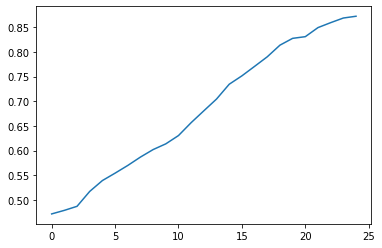

In [177]:
accuracies = []
for _ in range(25):
    accuracies.append(train_discriminator_on_batch(d, clean_dataset, white_dataset, verbose=False))
plt.plot(accuracies)

## Generator
The generator itself is a Convolutionnal Autoencoder.

Its input size and output size are both `sample_length`.

In [332]:
def create_complex_layer(inputs):
    return tf.complex(inputs[0], inputs[1])
def process_istft(inputs):
    p = tf.signal.inverse_stft(inputs, frame_length=nperseg, frame_step=nperseg, window_fn = tf.signal.inverse_stft_window_fn(nperseg))
    return tf.where(tf.math.is_nan(p), 0.0, p)

In [333]:
test = np.array(input_test1, dtype='float32')
#print(test)
x = process_istft(create_complex_layer((process_stft(test), process_stft_imag(test))))
print(x)
#plt.plot(test[0])

tf.Tensor(
[[0.0000000e+00 2.0949368e+00 1.5192417e+00 ... 3.8715171e+03
  7.4609785e+03 7.0918418e+03]], shape=(1, 1024), dtype=float32)


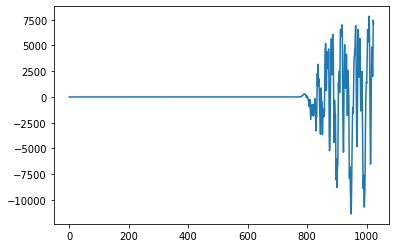

In [334]:
plt.plot(x[0])

In [335]:
  class ISTFTLayer(tf.keras.layers.Layer):
    def __init__(self, size):
        super(ISTFTLayer, self).__init__()
        self.size = size
        
    def call(self, inputs):
        input_shape = tf.shape(inputs)
        return tf.reshape(process_istft(inputs), (self.compute_output_shape(tf.shape(inputs))))

    def compute_output_shape(self, input_shape):
        return (-1, self.size)

Below, a tentative of STFT GAN: the complex part obtained is split into two layers: the real one (x0) and the imaginary one (y0).

The real part is processed through an autoencoder, before being re-added to the imaginary part. 

Then, the inverse STFT is processed.

It seems clear that the training process is impossible since there is no clear link between the output and the inner layers (since the inner layers are wrapped between STFT and inverse STFT layers).

Therefore, it could be a good approach to process the STFT on the input and expected data, and to train a GAN on the STFT.



In [401]:
def stft_generator(size):
    inputs = tf.keras.Input(shape=(size,))
    x0 = tf.keras.layers.Lambda(process_stft)(inputs)
    x1 = tf.keras.layers.Dense(513, activation='selu')(x0)    
    y0 = tf.keras.layers.Lambda(process_stft_imag)(inputs)
    z0 = tf.keras.layers.Lambda(create_complex_layer)((x1, y0))
    z1 = ISTFTLayer(size)(z0) 
    model = tf.keras.Model(inputs=inputs, outputs=z1, name="stft_autoencoder")
    model.summary()
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model

#g = stft_generator(samples_length)

Hereunder is another attempt of autoencoder, with one skip connection between the input and the last layer.
This comes from the assumption that there is a great part of the information in the input that could be used in itself to predict the output.

This architecture is quite simple, and lead to a slow (and not really convincing) learning, despite the facts that it learns.

In [422]:
def generator(size):
    inputs = tf.keras.Input(shape=(size,))
    x0 = tf.keras.layers.Dense(512, activation='tanh')(inputs)
    x1 = tf.keras.layers.Dense(256, activation='tanh')(x0)
    x2 = tf.keras.layers.Dense(512, activation='tanh')(x1)
    x4 = tf.keras.layers.Dense(size, activation='tanh')(x2)
    x5 = tf.keras.layers.Add()([inputs, x4])
    outputs = tf.keras.layers.Dense(size, activation='linear')(x5)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="autoencoder")
    model.summary()
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model

g = generator(samples_length)

Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_151 (InputLayer)          [(None, 1024)]       0                                            
__________________________________________________________________________________________________
dense_252 (Dense)               (None, 512)          524800      input_151[0][0]                  
__________________________________________________________________________________________________
dense_253 (Dense)               (None, 256)          131328      dense_252[0][0]                  
__________________________________________________________________________________________________
dense_254 (Dense)               (None, 512)          131584      dense_253[0][0]                  
________________________________________________________________________________________

### Pretraining the generator

In [423]:
accuracies = []
for _ in range(25):
    accuracies.append(g.fit(white_dataset, clean_dataset, batch_size=16, verbose=1).history["accuracy"])
plt.plot(accuracies)

456/667 [===================>..........] - ETA: 2s - loss: 12431257.7818 - accuracy: 0.0460

KeyboardInterrupt: 

In [ ]:
def generator(size):
    layers = []
    layers.append(tf.keras.Input(shape=(size,)))
    layers.append(tf.keras.layers.Dense(size)(layers[-1]))
    layers.append(tf.keras.layers.Dense(size//2)(layers[-1]))
    layers.append(tf.keras.layers.Reshape((size//2, -1))(layers[-1]))
    
    layers.append(tf.keras.layers.Conv1D(128, kernel_size = (4,),  activation="tanh", padding="same")(layers[-1]))
    layers.append(tf.keras.layers.MaxPooling1D(pool_size=2)(layers[-1]))
    
    
    layers.append(tf.keras.layers.UpSampling1D(size=2)(layers[-1]))
    layers.append(tf.keras.layers.Conv1DTranspose(1, kernel_size = (4,),  activation="tanh", padding="same")(layers[-1]))
    layers.append(tf.keras.layers.Flatten()(layers[-1]))
    
    layers.append(tf.keras.layers.Dense(size//2)(layers[-1]))
    layers.append(tf.keras.layers.Add()([layers[2], layers[-1]]))
    
    layers.append(tf.keras.layers.Dense(size)(layers[-1]))
    layers.append(tf.keras.layers.Add()([layers[1], layers[-1]]))
    model = tf.keras.Model(inputs=layers[0], outputs=layers[-1], name="skip_autoencoder")
    model.summary()
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model